# Political Evolution Simulator

This notebook implements a political simulation based on Selectorate Theory, where leaders evolve public/private goods allocation strategies over generations. Voters choose candidates based on ideology and expected benefits.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Parameters ---
N_VOTERS = 100             # Number of voters participating in each election
N_CANDIDATES = 3           # Number of candidates competing in each generation
N_GENERATIONS = 2000       # Number of election cycles to simulate
RESOURCE_POOL = 1000       # Total resources candidates can allocate between public and private goods
PUBLIC_GOODS_MUT_STD = 0.05 # Standard deviation of mutation applied to the public goods allocation (alpha)
POLICY_MUT_STD = 2         # Standard deviation of mutation applied to candidate policy positions
THETA = 15                 # Maximum ideological distance for voters to consider joining a candidate's coalition
TAU = 0.6                  # Threshold for inclusion probability if voter is risk-seeking
PHI = 0.3                  # Threshold for inclusion probability if voter is risk-averse


np.random.seed(1234)

## Voter Class
Each voter has an ideology and a risk type. They vote based on policy alignment and payoff expectations.

In [9]:
class Voter:
    def __init__(self, ideology, risk_type='safe'):
        self.ideology = ideology
        self.risk_type = risk_type

    def utility(self, candidate, coalition_prob, included):
        policy_loss = -(self.ideology - candidate.policy) ** 2
        public_payoff = candidate.alpha * (RESOURCE_POOL / N_VOTERS)
        private_payoff = (1 - candidate.alpha) * (RESOURCE_POOL / N_VOTERS) if included else 0
        return policy_loss + public_payoff + private_payoff

    def inclusion(self, candidate, coalition_prob):
        threshold = TAU if self.risk_type == 'risk' else PHI
        return abs(self.ideology - candidate.policy) <= THETA and coalition_prob >= threshold

## Candidate Class
Candidates have a policy and public/private goods strategy. They mutate their strategy to evolve.

In [10]:
class Candidate:
    def __init__(self, policy, alpha):
        self.policy = policy
        self.alpha = alpha
        self.supporters = set()
        self.winning_coalition = set()

    def mutate(self, mutate_policy=True):
        new_alpha = np.clip(self.alpha + np.random.normal(0, PUBLIC_GOODS_MUT_STD), 0, 1)
        new_policy = self.policy + np.random.normal(0, POLICY_MUT_STD) if mutate_policy else self.policy
        new_policy = np.clip(new_policy, 0, 100)
        return Candidate(new_policy, new_alpha)


## Simulation Class
Handles the election process, coalition formation, and candidate evolution.

In [11]:
class ElectionSim:
    def __init__(self):
        self.voters = [Voter(np.random.uniform(0, 100), np.random.choice(['safe', 'risk'])) for _ in range(N_VOTERS)]
        self.candidates = [Candidate(np.random.uniform(0, 100), np.random.uniform(0, 1)) for _ in range(N_CANDIDATES)]

    def run_generation(self, mutate_policy=True):
        ballots = []
        for voter in self.voters:
            utilities = []
            for cand in self.candidates:
                coalition_prob = len(cand.winning_coalition) / N_VOTERS if cand.winning_coalition else 1/N_VOTERS
                included = voter.inclusion(cand, coalition_prob)
                utilities.append(voter.utility(cand, coalition_prob, included))
            ballots.append(np.argmax(utilities))

        for idx, cand in enumerate(self.candidates):
            cand.supporters = {i for i, b in enumerate(ballots) if b == idx}
            supporters_list = list(cand.supporters)
            np.random.shuffle(supporters_list)
            cand.winning_coalition = set(supporters_list[:int(0.5 * N_VOTERS)])

        winner_idx = np.argmax([len(c.winning_coalition) for c in self.candidates])
        winner = self.candidates[winner_idx]

        new_candidates = [winner]
        while len(new_candidates) < N_CANDIDATES:
            new_candidates.append(winner.mutate(mutate_policy))
        self.candidates = new_candidates
        return winner, self.candidates

    def run_simulation(self, generations=N_GENERATIONS, mutate_policy=True):
        history = []
        for gen in range(generations):
            winner, candidates = self.run_generation(mutate_policy=mutate_policy)
            for idx, cand in enumerate(candidates):
                history.append({
                    'generation': gen,
                    'candidate_id': idx,
                    'policy': cand.policy,
                    'alpha': cand.alpha,
                    'is_winner': (cand == winner)
                })
        return pd.DataFrame(history)

## Run Simulation
Execute the simulation and observe the evolution of candidate strategies over generations.

In [12]:
sim = ElectionSim()
df = sim.run_simulation(mutate_policy=True)

## Plot Results
Visualize how winning policies and public/private allocations evolve over time.

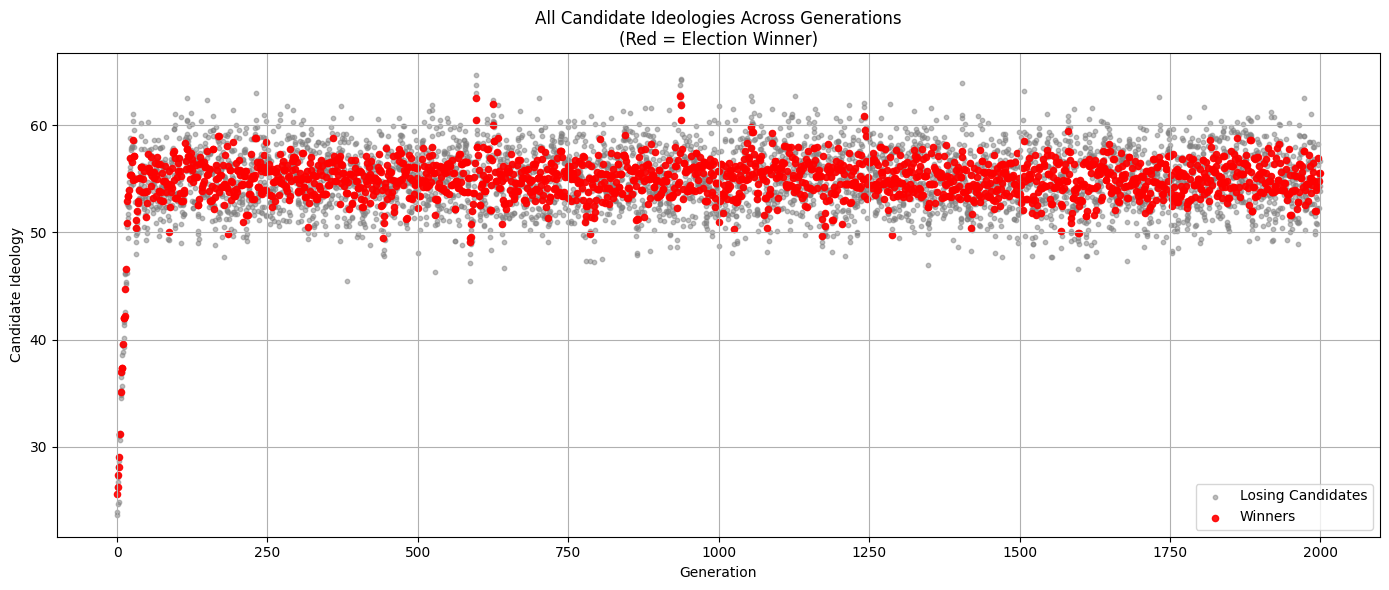

In [13]:
# Plot ideologies
plt.figure(figsize=(14, 6))
losers = df[df["is_winner"] == False]
winners = df[df["is_winner"] == True]

plt.scatter(losers["generation"], losers["policy"], color='gray', alpha=0.5, s=10, label='Losing Candidates')
plt.scatter(winners["generation"], winners["policy"], color='red', alpha=0.9, s=20, label='Winners')

plt.xlabel("Generation")
plt.ylabel("Candidate Ideology")
plt.title("All Candidate Ideologies Across Generations\n(Red = Election Winner)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

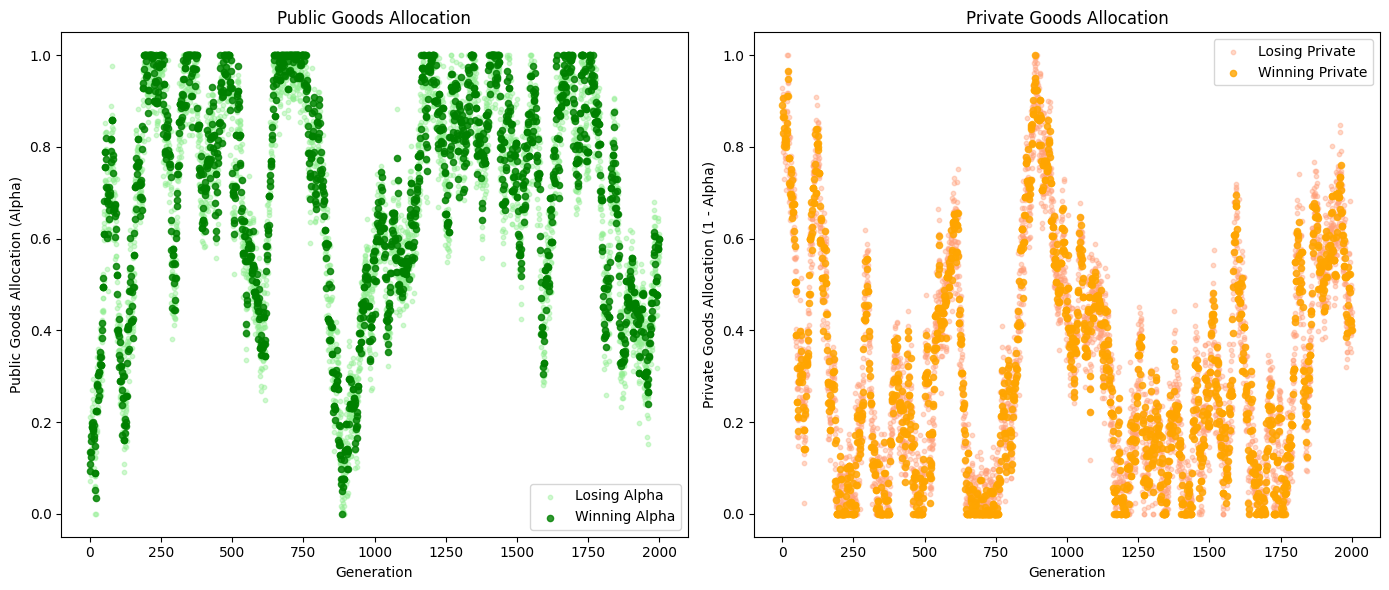

In [14]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(losers["generation"], losers["alpha"], color='lightgreen', alpha=0.4, s=10, label='Losing Alpha')
plt.scatter(winners["generation"], winners["alpha"], color='green', alpha=0.8, s=20, label='Winning Alpha')
plt.xlabel("Generation")
plt.ylabel("Public Goods Allocation (Alpha)")
plt.title("Public Goods Allocation")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(losers["generation"], 1 - losers["alpha"], color='lightsalmon', alpha=0.4, s=10, label='Losing Private')
plt.scatter(winners["generation"], 1 - winners["alpha"], color='orange', alpha=0.8, s=20, label='Winning Private')
plt.xlabel("Generation")
plt.ylabel("Private Goods Allocation (1 - Alpha)")
plt.title("Private Goods Allocation")
plt.legend()

plt.tight_layout()
plt.show()
